In [45]:
import json
import os
from os import path
from tqdm import tqdm
from tld import get_fld
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import colorama

def BOLD(txt):
    return colorama.Style.BRIGHT + str(txt) + colorama.Style.RESET_ALL

def DIM(txt):
    return colorama.Style.DIM + colorama.Fore.LIGHTBLACK_EX + str(txt) + colorama.Style.RESET_ALL


In [2]:
DATA_PATH = "/mnt/data/MT/pilot-crawl3"

def isCrawlDataFile(filename: str):
    return filename.endswith(".json") and filename != "metadata.json" and path.isfile(path.join(DATA_PATH, filename))

json_files = [f for f in os.listdir(DATA_PATH) if isCrawlDataFile(f)]
successfully_crawled_sites = len(json_files)
print("Found %d JSON files" % successfully_crawled_sites)

Found 683 JSON files


In [3]:
nr_of_timeouts = 0
saved_calls_sorted_by_type = {}

for filename in tqdm(json_files):
    with open(path.join(DATA_PATH, filename)) as file:
        first_encounter = json.load(file)
        url = first_encounter["initialUrl"]
        if first_encounter["timeout"]:
            nr_of_timeouts += 1

        # Sort saved calls
        ps_data = first_encounter["data"]["privacySandbox"]
        if not ps_data:
            continue
        saved_calls = ps_data["savedCalls"]
        if len(saved_calls) > 0:
            for saved_call in saved_calls:
                saved_call["initialUrl"] = url # include initialUrl in the saved call data

                call_type = saved_call["description"]
                if call_type not in saved_calls_sorted_by_type:
                    saved_calls_sorted_by_type[call_type] = []

                saved_calls_sorted_by_type[call_type].append(saved_call)

print("Number of timeouts:", nr_of_timeouts)


100%|██████████| 683/683 [00:11<00:00, 58.93it/s]

Number of timeouts: 67


### On which sites are the APIs being called?

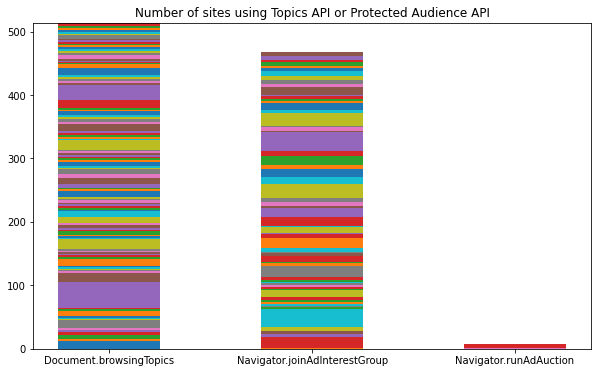

514 calls for Document.browsingTopics, on 114 distinct sites (16.69% of all successfully crawled sites)
	42 elmundo.es
	24 uol.com.br
	16 wikihow.com
	15 name.com
	14 elpais.com
	12 sohu.com
	12 teads.tv
	12 chess.com
	12 unity3d.com
	12 academia.edu
	...
468 calls for Navigator.joinAdInterestGroup, on 66 distinct sites (9.66% of all successfully crawled sites)
	30 wiley.com
	28 newrelic.com
	21 entrust.net
	20 constantcontact.com
	18 samsung.com
	17 hilton.com
	16 grammarly.com
	15 norton.com
	14 adcolony.com
	14 doordash.com
	...
7 calls for Navigator.runAdAuction, on 2 distinct sites (0.29% of all successfully crawled sites)
	6 yahoo.net
	1 ameblo.jp


In [47]:
first_encounter = {}
types = saved_calls_sorted_by_type.keys()
for i, (call_type, saved_calls) in enumerate(saved_calls_sorted_by_type.items()):
    for call in saved_calls:
        site = get_fld(call["initialUrl"])
        if not site in first_encounter:
            first_encounter[site] = np.zeros(len(types))
        first_encounter[site][i] += 1

width = 0.5

fig, ax = plt.subplots(1, 1, figsize=(10,6))
bottom = np.zeros(3)

for site, nr_of_calls in first_encounter.items():
    p = ax.bar(types, nr_of_calls, width, label=site, bottom=bottom)
    bottom += nr_of_calls

ax.set_title("Number of sites using Topics API or Protected Audience API")
plt.show()

for i, (call_type, saved_calls) in enumerate(saved_calls_sorted_by_type.items()):
    all_sites = [get_fld(call["initialUrl"]) for call in saved_calls]
    distinct_sites = sorted(set(all_sites), key=lambda d: all_sites.count(d), reverse=True)

    percentage = len(distinct_sites) / successfully_crawled_sites * 100
    print(BOLD("%d calls for %s, on %d distinct sites (%.2f%% of all successfully crawled sites)"
          % (len(saved_calls), call_type, len(distinct_sites), percentage)))
    for site in distinct_sites[:10]:
        print("\t%d %s" % (first_encounter[site][i], site))
    if len(distinct_sites) > 10:
        print("\t...")

Pilot crawl 2:
- 629 calls for Document.browsingTopics, on 98 distinct sites (13.41% of all successfully crawled sites)
- 141 calls for Navigator.joinAdInterestGroup, on 24 distinct sites (3.28% of all successfully crawled sites)
- 34 calls for Navigator.runAdAuction, on 4 distinct sites (0.55% of all successfully crawled sites)

### From which sources are the API calls coming?

In [49]:
for call_type, saved_calls in saved_calls_sorted_by_type.items():
    all_callers = dict()
    for call in saved_calls:
        caller = get_fld(call["source"])
        if caller not in all_callers:
            all_callers[caller] = set()
        all_callers[caller].add(get_fld(call["initialUrl"]))
    distinct_callers = sorted(all_callers.keys(), key=lambda d: len(all_callers[d]), reverse=True)

    all_sites = [get_fld(call["initialUrl"]) for call in saved_calls]
    distinct_sites = set(all_sites)

    print(BOLD("%d websites with calls for %s, from %d distinct callers" % (len(distinct_sites), call_type, len(distinct_callers))))
    for caller in distinct_callers:
        all_callers[caller] = sorted(all_callers[caller], key=lambda d: all_sites.count(d), reverse=True)
        print(("\t%d %s, %s" % (len(all_callers[caller]), caller, DIM(all_callers[caller])))[:110] + colorama.Style.RESET_ALL)

114 websites with calls for Document.browsingTopics, from 12 distinct callers
	66 licdn.com, ['name.com', 'unity3d.com', 'teads.tv', 'grammarly.com', 'sedo.com', 'hilton.com', 'qualtri
	20 criteo.com, ['elmundo.es', 'elpais.com', 'sohu.com', 'chess.com', 'nicovideo.jp', 'dailymotion.com', '
	19 doubleclick.net, ['elmundo.es', 'uol.com.br', 'wikihow.com', 'elpais.com', 'sohu.com', 'chess.com', 'a
	13 rubiconproject.com, ['uol.com.br', 'wikihow.com', 'elpais.com', 'chess.com', 'academia.edu', 'sohu.com
	12 taboola.com, ['elmundo.es', 'sohu.com', 'apnews.com', 'healthline.com', 'sedo.com', 'grammarly.com', '
	8 teads.tv, ['name.com', 'unity3d.com', 'teads.tv', 'squarespace.com', 'mailchi.mp', 'dashlane.com', 'mai
	6 creativecdn.com, ['elmundo.es', 'wikihow.com', 'elpais.com', 'alibaba.com', 'soundcloud.com', 'aliexpre
	3 top100.ru, ['livejournal.com', 'rambler.ru', 'sberdevices.ru']
	1 walmart.com, ['walmart.com']
	1 weborama.fr, ['rbc.ru']
	1 affec.tv, ['name.com']
	1 uol.com.br, ['uol.c

### Who are the interest group owners?

In [10]:
all_owners = [call["arguments"]["0"]["owner"] for call in saved_calls_sorted_by_type["Navigator.joinAdInterestGroup"]]
distinct_owners = sorted(set(all_owners), key=lambda d: all_owners.count(d), reverse=True)
print("%d distinct interest group owners:" % (len(distinct_owners)))
for owner in distinct_owners:
    print("\t%d %s" % (all_owners.count(owner), owner))

3 distinct interest group owners:
	433 https://td.doubleclick.net
	26 https://fledge.us.criteo.com
	9 https://fledge.eu.criteo.com


### Who are the auction sellers?

In [11]:
all_sellers = [call["arguments"]["0"]["seller"] for call in saved_calls_sorted_by_type["Navigator.runAdAuction"]]
distinct_sellers = sorted(set(all_sellers), key=lambda d: all_sellers.count(d), reverse=True)
print("%d distinct auction sellers:" % (len(distinct_sellers)))
for seller in distinct_sellers:
    print("\t%d %s" % (all_sellers.count(seller), seller))

1 distinct auction sellers:
	7 https://securepubads.g.doubleclick.net


### Did the calls come from crawled subpages?

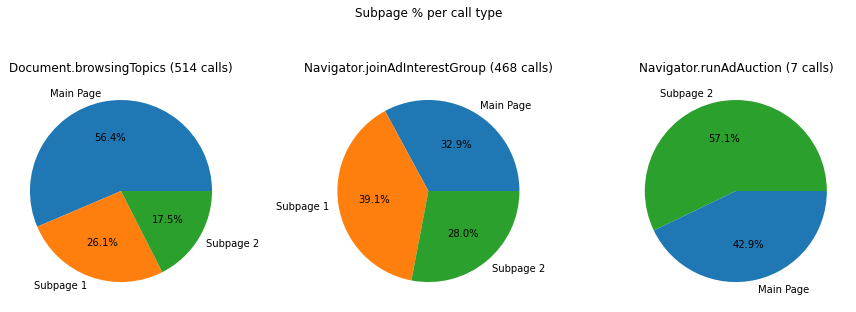

In [35]:
fig, axs = plt.subplots(1, len(saved_calls_sorted_by_type.keys()), figsize=(12,5))
fig.patch.set_facecolor('white')
fig.suptitle("Subpage % per call type")

for i, (call_type, saved_calls) in enumerate(saved_calls_sorted_by_type.items()):
    subpages = [call["subpageIndex"] for call in saved_calls]
    subpageCount = Counter(subpages)
    labels = ["Main Page" if s == -1 else "Subpage %d" % (s + 1) for s in subpageCount.keys()]
    colors = ["C" + str(s+1) for s in subpageCount.keys()]
    axs[i].pie(subpageCount.values(), labels=labels, autopct="%1.1f%%", colors=colors)
    axs[i].set_title("%s (%d calls)" % (call_type, len(saved_calls)))

plt.tight_layout()
plt.show()

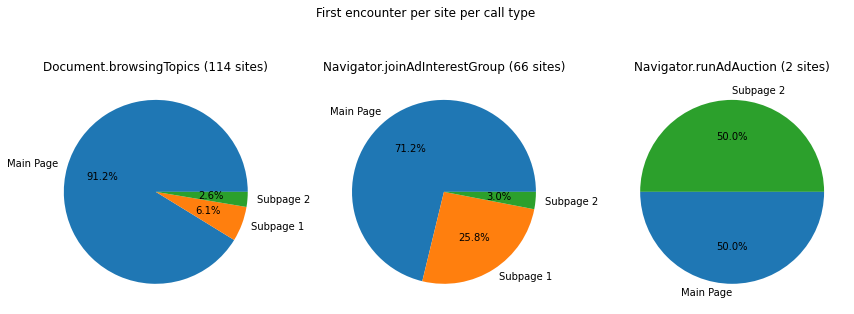

In [36]:
types = saved_calls_sorted_by_type.keys()
first_encounter = {ty: dict() for ty in types}
for i, (call_type, saved_calls) in enumerate(saved_calls_sorted_by_type.items()):
    for call in saved_calls:
        site = get_fld(call["initialUrl"])
        subpage = call["subpageIndex"]
        if site not in first_encounter[call_type] or subpage < first_encounter[call_type][site]:
            first_encounter[call_type][site] = subpage

fig, axs = plt.subplots(1, len(saved_calls_sorted_by_type.keys()), figsize=(12,5))
fig.patch.set_facecolor('white')
fig.suptitle("First encounter per site per call type")

for i, (call_type, sites) in enumerate(first_encounter.items()):
    subpages = sites.values()
    subpageCount = Counter(subpages)
    labels = ["Main Page" if s == -1 else "Subpage %d" % (s + 1) for s in subpageCount.keys()]
    colors = ["C" + str(s+1) for s in subpageCount.keys()]
    axs[i].pie(subpageCount.values(), labels=labels, autopct="%1.1f%%", colors=colors)
    axs[i].set_title("%s (%d sites)" % (call_type, len(sites)))

plt.tight_layout()
plt.show()